In [1]:
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

심층 신경망을 훈련할 때 발생할 수 있는 문제들
* *그레디언트 손실 또는 폭주* 문제 - 심층 신경망의 아래쪽으로 갈수록 그레디언트가 점점 작아지거나 커지는 현상
* 대규모 신경망을 위한 훈련 데이터가 충분하지 않거나 레이블을 만드는 작업에 비해 비용이 너무 많이 듬
* 훈련이 극단적으로 느려질 수 있음
* 수백만 개의 파라미터를 가진 모델은 훈련 세트에 과대적합될 위험이 매우 큼

참고하면 좋은 것 : https://www.slideshare.net/yongho/ss-79607172

# Summary

기본 DNN 설정
* 커널초기화 : He 초기화
* 활성화 함수 : ELU
* 정규화 : Batch Normalization
* 규제 : Early Stop
* 옵티마이저 : 모멘턴 최적화, RMSProp, Nadam
* 학습률 스케줄 : 1사이클

# 1. 그레디언트 소실과 폭주 문제

역전파 알고리즘을 통해 모든 파라미터에 대해 오차 함수의 그레디언트를 계산하면 경사 하강법 단계에서 이 그레디언트를 사용하여 각 파라미러틑 수정한다. 그런데 알고리즘이 하위층으로 진행될수록 그레디언트가 점점 작아지는 경우가 발생한다. 이 문제를 **Vanishing Gradient**라고 한다.

In [5]:
def logit(z):
    return 1 / (1 + np.exp(-z))

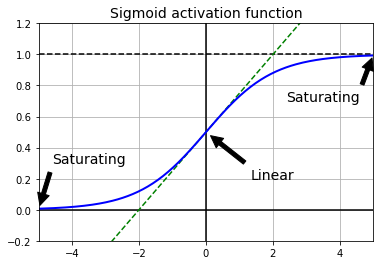

In [7]:
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

plt.show()

이러한 문제의 원인은, 많이 사용되는 로지스틱 시그모이드 활성화함수와 그 당시 가장 인기 있던 가중치 초기화 방법(평균이 0이고 표준편차가 1인 정규분포)의 조합이었다. 이 활성화 함수와 초기화 방법을 사용했을 때 각 층에서 출력의 분산이 입력의 분산보다 더 크다는 것을 밝혀냈다. 신경망의 위쪽으로 갈수록 층을 지날 때마다 분산이 계속 커져 가장 높은 층에서는 활성화함수가 0이나 1로 수렴한다. 이는 로지스틱 함수의 평균이 0이 아니고 0.5라는 사실 때문에 더 나빠진다.

로지스틱 활성화 함수를 보면 입력이 (양수나 음수로) 커지면 0이나 1로 수렴해서 기울기가 0에 매우 가까워지는 것을 알 수 있다. 그래서 역전파가 될 때 사실상 신경망으로 전파할 그레디언트가 거의 없고 조금 있는 그레디언트는 최상위층에서부터 역전파가 진행되면서 점차 약해져서 실쩨로 아래쪽 층에는 아무 것도 도달하지 않게 된다.

## 1.1 글로럿과 He 초기화

예측할 때는 정방향으로, 그레디언트를 역전파할 때는 역방향으로 양방향 신호가 적절하게 흘러야 한다. 저자들은 적절한 신호가 흐르기 위해서는 각 층의 출력에 대한 분산이 입력에 대한 분산과 같아야 한다구 주장한다. 그리고 역방향에서 층을 통과하기 전과 후의 그레디언트 분산이 동일해야 한다.  
$$fan_{avg}=(fan_{in}+fan_{out})/2$$
* $fan_{in}$, $fan_{out}$ : 층의 입력과 출력 연결 갯수
  
이 초기화 전략을 저자의 이름을 따서 **세이비어 초기화(Xavier initialization) 또는 글로럿 초기화(Glorot initialization)** 라고 한다.

케라스는 기본적으로 균등분포의 글로럿 초기화를 사용한다.

In [ ]:
keras.layers.Dense(10, activation="relu", kernel_initializer="he_normal") #

## 1.2 수렴하지 않는 활성화 함수

활성화 함수를 잘못 선택하면 자칫 그레디언트의 소실이나 폭주로 이어질 수 있다. 그 전에는 sigmoid 활성화 함수가 최선의 선택으로 알려져 있었으나, ReLU 활성화 함수가 심층 신경망에서 훨씬 더 잘 작동한다는 사실이 밝혀졌다.

ReLU 또한 훈련하는 동안 일부 뉴런이 0 이외의 값을 출력하지 않는 dying ReLU 문제가 존재한다. 어떤 경우에는(특히 큰 학습률을 사용하면) 신경망의 뉴런 절반이 죽어있기도 하다.  
이 문제를 해결하기 위해 **LeakyReLU**같은 ReLU의 변종을 사용한다.
$$LeakyReLU_{\alpha}(z) = max(\alpha z, z)$$
* 하이퍼파라미터 $\alpha$ : 이 함수가 새는(leaky)정도를 결정
* 새는 정도란, z<0 일 때 이 함수의 기울기이며, 일반적으로 0.01로 설정
  
최근 논문에서는 여러 ReLU 함수의 변종을 비교해 얻은 결론 하나는 LeakyReLU가 ReLU보다 항상 성능이 높다는 것이다.

In [8]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

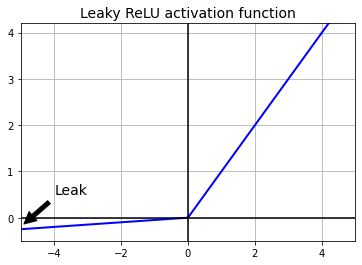

In [9]:
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

plt.show()

model = keras.models.Sequential(

In [ ]:
model = keras.models.Sequential([
    [...]
    keras.layers.Dense(10, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(alpha=0.2),
    [...]
])

그 외에 **ELU(Exponential linear unit), SELU(Scaled ELU)** 등이 존재한다.

In [10]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

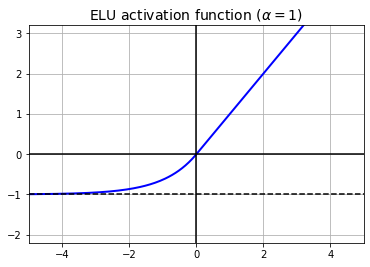

In [11]:
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

plt.show()

In [12]:
from scipy.special import erfc

# alpha와 scale은 평균 0과 표준 편차 1로 자기 정규화합니다
# (논문에 있는 식 14 참조):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)

In [13]:
def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

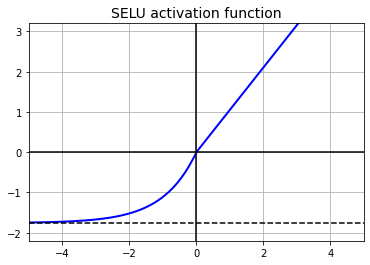

In [15]:
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title("SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

plt.show()

In [ ]:
keras.layers.Dense(10, activation="selu", kernel_initializer="lecun_normal")

## 1.3 Batch Normalization

이 기법은 각 층에서 활성화 함수를 통과하기 전이나 후에 모델에 연산을 하나 추가한다. 이 연산은 단순하게 입력을 원점에 맞추고 정규화한 다음, 각 층에서 두 개의 새로운 파라미터로 결과값의 스케일을 조어하고 이동시킨다. 하나는 스케일 조정에, 다른 하나는 이동에 상요한다. 많은 경우 신경망의 첫 번째 층으로 배치 정규화를 추가하면 훈련 세트를 표준화할 필요가 없다. 배치 정규화 층이 이런 역할을 대신 한다.

$$\mu_B = \frac{1}{m_B}\sum_{i=1}^{m_B}x^{(i)}$$
$$\sigma_B^2=\frac{1}{m_B}\sum_{i=1}^{m_B}(x^{(i)}-\mu_B)^2$$
$$\hat{x}^{(i)}=\frac{x^{(i)}-\mu_B}{\sqrt{\sigma_B^2+\epsilon}}$$
$$z^{(i)}=\gamma \times \hat{x}^{(i)}+\beta$$
* $\mu_b$ : 미니배치 B에 대해 평가한 입력의 평균 벡터
* $\sigma_B$ : 미니배치 B에 대해 평가한 입력의 표준편차 벡터
* $m_B$ : 미니배치에 있는 샘플 수
* $\hat{x}^{(i)}$ : 평균이 0이고 정규화된 샘플 i의 입력
* $\gamma$ : 층의 출력 스케일 파라미터 벡터(입력마다 하나의 스케일 파라미터가 있음)
* $\times$ : 원소별 곱셈(element-wise multiplication)
* $\beta$ : 층의 출력 이동(오프셋) 파라미터 벡터, 각 입력은 해당 파라미터만큼 이동함
* $\epsilon$ : 분모가 0이 되는 것을 막히 위한 작은 숫자(smoothing term)
* $z^{(i)}$ : 배치 정규화 연산의 출력, 즉 입력의 스케일을 조정하고 이동시킨 것

In [17]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(30, activation="elu", kernel_initializer="he_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(30, activation="elu", kernel_initializer="he_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 784)               3136      
_________________________________________________________________
dense (Dense)                (None, 30)                23550     
_________________________________________________________________
batch_normalization_1 (Batch (None, 30)                120       
_________________________________________________________________
dense_1 (Dense)              (None, 30)                930       
_________________________________________________________________
batch_normalization_2 (Batch (None, 30)                120       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                3

## 1.4 Gradient Clipping

역전파될 때 일정 임곗값을 넘어서지 못하게 그레디언트를 잘라내는 방법이다. 순환 신경망은 배치 정규화를 적용하기 어려워서 이 방법을 많이 사용한다.

In [ ]:
optimizer = keras.optimizers.SGD(clipvalue=1.0)
model.compile(loss="mse", optimizer=optimizer)

이 옵티마이저는 그레디언트 벡터의 모든 원소를 -1.0과 1.0 사이로 클리핑한다. 즉 훈련되는 각 파라미터에 대한 손실의 모든 편미분 값을 -1.0에서 1.0으로 잘라낸다. 임계값은 하이퍼파라미터로 튜닝할 수 있다.

# 2. 전이학습(Transfer Learning)

일반적으로 아주 큰 규모의 DNN을 처음부터 새로 훈련하는 것은 좋지 않다. 해결하려는 것과 비슷한 유형의 문제를 처리한 신경망이 있는지 찾아본 다음, 그 신경망의 하위층을 재사용하는 것이 좋다. 이를 **전이학습(Transfer Learning)** 이라고 한다. 이 방법은 훈련 속도를 크게 높일 뿐만 아니라 필요한 훈련 데이터도 크게 줄여준다.

보통 원본 모델의 출력층을 변경해야 한다. 이 층이 새로운 작업에 가장 유용하지 않는 층이고 새로운 작업에 필요한 출력 갯수와 맞지 않을 수 있다. 비슷하게 원본 모델의 상위 은닉층은 하위 은닉층보다 덜 유요하다. 새로운 작업에 유용한 고수준 특성은 원본 작업에서 유용했던 특성과 상당히 다르기 때문이다. 재사용할 층 갯수를 잘 선정하는 것이 필요하다.

재사용하는 층은 가중치를 고정시켜 훈련되지 않도록 한다. 그 다음 모델을 훈련하고 성능을 평가한다. 맨 위에 있는 몇 개의 은닉층의 동결을 해제하고 역전파를 통해 가중치를 조정하여 성능이 향상되는지 확인한다. 훈련 데이터가 많을 수록 많은 층의 동결을 해제할 수 있다. 재사용 층의 동결을 해제할 때는 학습률을 줄이는 것이 가중치를 세밀하게 튜닝하는데 도움이 된다.

패션 MNIST 훈련 세트를 두 개로 나눈다:
* `X_train_A`: 샌달과 셔츠(클래스 5와 6)을 제외한 모든 이미지
* `X_train_B`: 샌달과 셔츠 이미지 중 처음 200개만 가진 작은 훈련 세트
  
검증 세트와 테스트 세트도 이렇게 나누지만 하지만 이미지 개수는 제한하지 않는다.
  
A 세트(8개의 클래스를 가진 분류 문제)에서 모델을 훈련하고 이를 재사용하여 B 세트(이진 분류)를 해결하려고 한다. A 작업에서 B 작업으로 약간의 지식이 전달되기를 기대하는데, 왜냐하면 A 세트의 클래스(스니커즈, 앵클 부츠, 코트, 티셔츠 등)가 B 세트에 있는 클래스(샌달과 셔츠)와 조금 비슷하기 때문이다. 하지만 `Dense` 층을 사용하기 때문에 동일한 위치에 나타난 패턴만 재사용할 수 있다(반대로 합성곱 층은 훨씬 많은 정보를 전송한다. 학습한 패턴을 이미지의 어느 위치에서나 감지할 수 있기 때문이다).

In [2]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [3]:
def split_dataset(X, y):
    y_5_or_6 = (y == 5) | (y == 6) # sandals or shirts
    y_A = y[~y_5_or_6]
    y_A[y_A > 6] -= 2 # class indices 7, 8, 9 should be moved to 5, 6, 7
    y_B = (y[y_5_or_6] == 6).astype(np.float32) # binary classification task: is it a shirt (class 6)?
    return ((X[~y_5_or_6], y_A),
            (X[y_5_or_6], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

In [4]:
print(X_train_A.shape)
print(X_train_B.shape)

(43986, 28, 28)
(200, 28, 28)


In [5]:
y_train_A[:10]

array([4, 0, 5, 7, 7, 7, 4, 4, 3, 4], dtype=uint8)

In [6]:
y_train_B[:10]

array([1., 1., 0., 0., 0., 0., 1., 1., 1., 0.], dtype=float32)

In [8]:
model_A = keras.models.Sequential()
model_A.add(keras.layers.Flatten(input_shape=[28,28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_A.add(keras.layers.Dense(n_hidden, activation="relu"))
model_A.add(keras.layers.Dense(8, activation="softmax"))

In [11]:
model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1e-3),
                metrics=["accuracy"])

In [13]:
history = model_A.fit(X_train_A, y_train_A, epochs=20, 
                      validation_data=(X_valid_A, y_valid_A))

Epoch 1/20
1375/1375 [==============================] - 1s 856us/step - loss: 1.8662 - accuracy: 0.3245 - val_loss: 1.0566 - val_accuracy: 0.7095
Epoch 2/20
1375/1375 [==============================] - 1s 726us/step - loss: 0.8795 - accuracy: 0.7597 - val_loss: 0.5572 - val_accuracy: 0.8146
Epoch 3/20
1375/1375 [==============================] - 1s 683us/step - loss: 0.5290 - accuracy: 0.8240 - val_loss: 0.4451 - val_accuracy: 0.8426
Epoch 4/20
1375/1375 [==============================] - 1s 716us/step - loss: 0.4439 - accuracy: 0.8440 - val_loss: 0.4011 - val_accuracy: 0.8545
Epoch 5/20
1375/1375 [==============================] - 1s 734us/step - loss: 0.4035 - accuracy: 0.8571 - val_loss: 0.3651 - val_accuracy: 0.8732
Epoch 6/20
1375/1375 [==============================] - 1s 683us/step - loss: 0.3753 - accuracy: 0.8672 - val_loss: 0.3456 - val_accuracy: 0.8819
Epoch 7/20
1375/1375 [==============================] - 1s 718us/step - loss: 0.3515 - accuracy: 0.8771 - val_loss: 0.3426 -

In [14]:
model_A.save("my_model_A.h5")

## 2.1 케라스를 활용한 전이학습

In [16]:
model_A = keras.models.load_model("my_model_A.h5")

In [18]:
# 클론을 하지 않고 model_A를 사용할 경우, model_B_on_A를 학습할 때 model_A도 영향을 받음
model_A_clone = keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights()) # clone_model은 가중치를 클론하진 않기 때문에 model_A의 가중치를 복사
model_B_on_A = keras.models.Sequential(model_A_clone.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

새로운 출력층이 랜덤하게 초기화되어 있기 때문에 처음 몇번의 에포크 동안에는 큰 오차를 만들 수 있고, 큰 오차 그레디언트가 재사용된 가중치를 망칠 수 있다. 이를 피하는 한 가지 방법은 처음 몇 번의 에포크 동안 재사용된 층을 동결하고 새로운 층에게 적절한 가중치를 학습할 시간을 주는 것이다. 이를 위해 모든 층의 trainable 속성을 `False`로 지정하고 모델을 컴파일한다.

In [19]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

In [20]:
model_B_on_A.compile(loss="binary_crossentropy", optimizer="sgd", metrics=["accuracy"])

몇 번의 에포크 동안 모델을 훈련하고, 그 다음 재사용된 층의 동결을 해제하고(모델을 다시 컴파일해야 함) 작업 B에 맞게 재사용된 층을 세밀하게 튜닝하기 위해 훈련을 계속한다. 일반적으로 재사용된 층의 동결을 해제한 후에 학습률을 낮추는 것이 좋다. 이렇게 하면 재사용된 가중치가 망가지는 것을 막아준다.

In [21]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))

# 학습이 가능하도록 동결 해제
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

optimizer = keras.optimizers.SGD(lr=1e-4) # 기본 학습률을 1e-2
model_B_on_A.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"]) # 동결 해제 후 재 컴파일

history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

Epoch 1/4
7/7 [==============================] - 0s 17ms/step - loss: 1.3691 - accuracy: 0.6428 - val_loss: 0.3514 - val_accuracy: 0.9574
Epoch 2/4
7/7 [==============================] - 0s 6ms/step - loss: 0.3099 - accuracy: 0.9756 - val_loss: 0.2505 - val_accuracy: 0.9787
Epoch 3/4
7/7 [==============================] - 0s 6ms/step - loss: 0.2235 - accuracy: 0.9862 - val_loss: 0.2028 - val_accuracy: 0.9868
Epoch 4/4
7/7 [==============================] - 0s 5ms/step - loss: 0.1827 - accuracy: 0.9924 - val_loss: 0.1724 - val_accuracy: 0.9878
Epoch 1/16
7/7 [==============================] - 0s 17ms/step - loss: 0.1654 - accuracy: 0.9937 - val_loss: 0.1715 - val_accuracy: 0.9888
Epoch 2/16
7/7 [==============================] - 0s 5ms/step - loss: 0.1557 - accuracy: 0.9823 - val_loss: 0.1707 - val_accuracy: 0.9888
Epoch 3/16
7/7 [==============================] - 0s 6ms/step - loss: 0.1559 - accuracy: 0.9931 - val_loss: 0.1700 - val_accuracy: 0.9888
Epoch 4/16
7/7 [====================

**전이 학습은 작은 Fully Connected Network**에서는 잘 동작하지 않기 때문에 사용에 주의를 해야한다.

## 2.2 비지도 사전훈련

레이블된 훈련 데이터가 많지 않은 복잡한 문제인데 비슷한 작업에 대한 훈련된 모델을 찾을 수 없는 경우가 있다. 이런 경우에는 **비지도 사전훈련(Unsupervised Pretraining)** 을 수행할 수 있다.

레이블되지 않은 훈련 데이터를 많이 모을 수 있다면 이를 사용하여 오토인코더나 GAN과 같은 비지도 학습 모델을 훈련할 수 있다. 그 다음 오토인코더나 GAN 판별자의 하위층을 재사용하고 그 위에 새로운 작업에 맞는 출력층을 추가할 수 있다. 그 다음 지도 학습으로(즉, 레이블된 훈련 샘플로) 최종 네트워크를 세밀하게 튜닝한다.

# 3. Optimizer

아주 큰 심층 신경망의 훈련 속도는 심각하게 느릴 수 있다. 지금까지 다음과 같은 훈련 속도를 높이는 방법을 보았다.
* 연결 가중치에 좋은 초기화 전략 적용하기(he Initialization 등)
* 좋은 활성화 함수 사용하기(ReLU 연관 함수)
* 배치 정규화 사용하기
* 사전 훈련된 네트워크의 일부 사용하기(Transfer Learning)
  
훈련 속도를 크게 높일 수 있는 또 다른 방법으로 표준적인 경사하강법 옵티마이저 대신 더 빠른 옵티마이저를 사용할 수있다.

## 3.1 Momentum Optimizer

볼링공이 매끈한 표면의 완만한 경사를 굴러갈 때, 처음에는 느리게 출발하지만 종단속도에 도달할 때까지는 빠르게 가속된다. 이 것이 모멘텀 최적화의 간단한 원리이다. 반대로 표준적인 경사 하강법은 경사면을 따라 일정한 크기의 스텝으로 조금씩 내려간다. 그래서 맨 아래에 도착하는데 시간이 더 오래 걸린다.

경사 하강법은 가중치에 대한 비용함수 $J(\theta)$의 그레디언트$\bigtriangledown_{\theta}J(\theta)$에 학습률 $\eta$를 곱한 것을 바로 차감하여 가중치 $\theta$를 갱신한다($\theta \leftarrow \theta - \eta \bigtriangledown_{\theta}J(\theta)$). 이 식은 이전의 그레디언트가 얼마였는지는 고려하지 않았다. 국부적으로 그레디언트가 아주 작으면 매우 느려질 것이다.

모멘텀 최적화는 이전 그레디언트가 얼마였는지를 상당히 중요하게 생각한다. 매 반복에서 현재 그레디언트를 (학습률 $\eta$를 곱한 후) **모멘텀 벡터 m**에 더하고 이 값을 뺴는 방식으로 가중치를 갱신한다. 즉 그레디언트를 속도가 아니라 가속도로 사용한다. 일종의 마찰저항을 표현하고 모멘텀이 너무 커지는 것을 막기 위해 이 알고리즘에는 **모멘텀**이라는 새로운 하이퍼파라미터 $\beta$가 있다. 이 값은 0(높은 마찰저항)과 1(마찰저항 없음) 사이로 설정되어야 한다. 일반적인 모멘텀 값은 0.9이다.
$$m \leftarrow \beta m - \eta \bigtriangledown_{\theta}J(\theta)$$
$$\theta \leftarrow \theta + m$$

In [22]:
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9)

## 3.2 네스테로프 가속 경사

모멘텀 최적화의 한 변종으로 기본 모멘텀 최적화보다 거의 항상 더 빠르다. 현재 위치가 $\theta$가 아닌 모멘텀의 방향으로 조금 앞선 $\theata+\beta m$에서 비용 함수의 그레디언트를 계산하는 것이다.
$$m \leftarrow \beta m - \eta \bigtriangledown_{\theta}J(\theta + \beta m)$$
$$\theta \leftarrow + m$$
  
일반적으로 모멘텀 벡터가 올바른 방향(즉, 최적점을 향하는 방향)을 가리킬 것이므로 이런 변경이 가능하다.

In [23]:
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9, nesterov=True)

## 3.3 AdaGrad

가장 가파른 차원을 따라 그레디언트 벡터의 스케일을 감소시켜 전역 최적점 쪽으로 좀 더 정확한 방향을 잡도록 해준다.
$$s \leftarrow s+\bigtriangledown_{\theta}J(\theta) \otimes \bigtriangledown_{\theta}J(\theta)$$
$$\theta \leftarrow \theta - \eta \bigtriangledown_{\theta}J(\theta)\oslash \sqrt{s+\epsilon}$$

요악하면 이 알고리즘은 학습률을 감소시키지만 경사가 완만한 차원보다 가파른 차원에 대해 더 빠르게 감소된다. 이를 적응적 학습률이라고 부르며, 전역 최적점 방향으로 더 곧장 가도록 갱신되는데 도움이 된다. 학습률 하이퍼파라미터 $\eta$를 덜 튜닝해도 되는 점이 또 하나의 장점이다.

AdaGrad는 간단한 2차방정식 문제에 대해서는 잘 작동하지만 신경망을 훈련할 때 너무 일찍 멈추는 경우가 종종 있다. 학습률이 너무 감소되어 전역 최적점에 도착하기 전에 알고리즘이 완전히 멈춘다. 그래서 케라스에 Adagrad 옵티마이저가 있지만 심층 신경망에는 사용하지 말아야 한다.

## 3.4 RMSProp

AdaGrad는 너무 빨리 느려져서 전역 최적점에 수렴하지 못하는 위험이 있는데, RMSProp 알고리즘은 훈련 시작부터의 모든 그레디언트가 아닌 가장 최근 반복에서 비롯된 그레디언트만 누적함으로써 이 문제를 해결했다.
$$s \leftarrow \beta s + (1-\beta)\bigtriangledown_{\theta}J(\theta)\otimes \bigtriangledown_{\theta}J(\theta)$$
$$\theta \leftarrow \theta - \eta \bigtriangledown_{\theta}J(\theta)\oslash \sqrt{s+\epsilon}$$

보통 감쇠율 $\beta$는 0.9로 설정하지만 기본값이 잘 작동하는 경우가 많으므로 이를 튜닝할 필요는 전혀 없다.

In [24]:
optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9)

## 3.5 Adam과 Nadam 최적화

적응적 모멘트 추정을 의미하는 **Adam(Adaptive Moment Estimation)** 은 모멘텀 최적화와 RMSProp의 아이디어를 합친 것이다. 모멘텀 최적화처럼 지난 그레디언트의 지수 감소 평균을 따르고 RMSProp처럼 지난 그레디언트 제곱의 지수 감소의 평균을 따른다.
$$m \leftarrow \beta_1 m-(1-\beta_1)\bigtriangledown_{\theta}J(\theta)$$
$$s \leftarrow \beta_2 s+(1-\beta_1)\bigtriangledown_{\theta}\otimes\bigtriangledown_{\theta}J(\theta)$$
$$\hat{m} \leftarrow \frac{m}{1-\beta_1^t}$$
$$\hat{s} \leftarrow \frac{s}{1-\beta_2^t}$$
$$\theta \leftarrow \theta + \eta\hat{m}\oslash\sqrt{\hat{s}+\epsilon}$$

모멘텀 감쇠 하이퍼파라미터 $\beta_1$은 보통 0.9로 초기화하고 스케일 감쇠 하이퍼파라미터 $\beta_2$는 0.999로 초기화 하는 경우가 많다. 안정된 계산을 위해 $\epsilon$은 보통 $10^{-7}$같은 아주 작은 수로 초기화한다. 이것이 Adam 클래스의 기본값이다.

In [25]:
optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

## 3.6 학습률 스케줄링

큰 학습률로 시작하고 학습 속도가 느려질 때 학습률을 낮추면 최적의 고정 학습률보다 좋은 솔루션을 더 빨리 발견할 수 있다. 다음은 가장 널리 사용하는 학습 스케줄이다.
* 거듭제곱 기반 스케줄링
* 지수 기반 스케줄링
* 구간별 고정 스케줄링
* 성능 기반 스케줄링
* 1사이클 스케줄링

In [26]:
optimizer = keras.optimizers.SGD(lr=0.01, decay=1e-4)

# 4. Regularization

신경망이 과대적합 되는 것을 막기 위한 방법으로 규제가 있다.

## 4.1 $l_1$과 $l_2$ 규제

In [29]:
layer = keras.layers.Dense(100, activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))

In [31]:
from functools import partial

Regularized_dense = partial(keras.layers.Dense,
                            activation="elu",
                            kernel_initializer="he_normal",
                            kernel_regularizer=keras.regularizers.l2(0.01))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    Regularized_dense(300),
    Regularized_dense(100),
    Regularized_dense(10, activation="softmax", kernel_initializer="glorot_uniform")
])

## 4.2 Dropout

드롭아웃은 심층 신경망에서 가장 인기 있는 규제 기법 중 하나이다. 매 훈련 스텝마다 각 뉴런(입력 뉴런은 포함하고 출력 뉴런은 제외)은 임시적으로 드롭아웃될 확률 p를 가진다. 즉, 이번 훈련 스텝에는 완전히 무시되지만 다음 스텝에는 활성화될 수 있다. 하이퍼파라미터 p를 드롭아웃 비율이라고 하고 보통 10%와 50% 사이를 지정한다. RNN에서는 20%에서 30%에 가깝고 CNN에서는 40%에서 50%에 가깝다. 훈련이 끝난 후에는 뉴런에 더는 드롭아웃을 적용하지 않는다.
* 일반적으로 출력층을 제외한 맨 위의 층부터 세 번째 층까지 있는 뉴런에만 드롭아웃을 적용한다.

In [32]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])

* 많은 최신의 신경망 구조는 마지막 은닉층 뒤에만 드롭아웃을 사용한다.